In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sqlite3
import seaborn as sns
from dataclasses import dataclass, field
from typing import Dict, Tuple, Iterable
from Utils.Plot_Helper import plot_1d_data, plot_gaussian_node
from Utils.Metrics import rmse, nll, node_metrics
from Filters.KalmanFilter import KalmanFilterSmoother
from Systems import UniformNonlinearGrowthModel, BearingsOnlyTracking, BearingsOnlyTrackingTurn
from MomentMatching.Estimator import Estimator
from MomentMatching import UnscentedTransform, MonteCarloTransform, TaylorTransform
from ExpectationPropagation.Nodes import build_nodes, node_estimator, node_system
from ExpectationPropagation.Iterations import ep_iterations, ep_fwd_back_updates
from Experiments.FullSweep import select_transform
from copy import deepcopy

## Gaussian filtering and smoothing

First, we generate the trajectories (latent states) and observations of a given dynamical system. Here, we choose the uniform nonlinear growth model (UNGM).

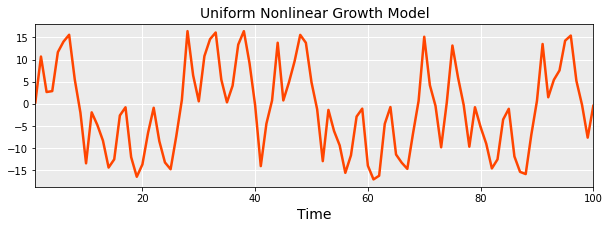

In [2]:
system = UniformNonlinearGrowthModel()
timesteps = 100
SEED = 801
np.random.seed(seed=SEED)
data = system.simulate(timesteps)
_, X, _, y = zip(*data)

# Plot ground truth trajectory
ax = plot_1d_data(np.array(X).T, figsize=(10,3), linewidth=2.5, c='orangered')
ax.set_title('Uniform Nonlinear Growth Model', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_xlim(1, timesteps)
plt.show()

Before using Expectation Propagation (EP), let us first apply a standard nonlinear filter/smoother to get an estimate of the latent states X above from observations y.

In [3]:
def select_transform(id='UT', dim=1, samples=int(5e4), alpha1=1, alpha2=1, beta1=2, beta2=2, kappa1=3, kappa2=2):

    if id.upper() == 'UT':
        transition_transform = UnscentedTransform(dim=dim, beta=beta1, alpha=alpha1, kappa=kappa1)
        measurement_transform = UnscentedTransform(dim=dim, beta=beta2, alpha=alpha2, kappa=kappa2)

    elif id.upper() == 'TT':
        transition_transform = TaylorTransform(dim=dim)
        measurement_transform = TaylorTransform(dim=dim)

    elif id.upper() == 'MCT':
        transition_transform = MonteCarloTransform(dim=dim, number_of_samples=samples)
        measurement_transform = MonteCarloTransform(dim=dim, number_of_samples=samples)

    else:
        transition_transform = UnscentedTransform(dim=dim, beta=2, alpha=1, kappa=3)
        measurement_transform = UnscentedTransform(dim=dim, beta=2, alpha=1, kappa=2)

    return transition_transform, measurement_transform

Choose the (implicit or explicit) linearisation method. Here, we choose the unscented transform (UT).

In [5]:
trans_type = 'UT' # Choices available: 'TT' (Taylor transform), 'UT' (unscented transform), 'MCT' (Monte-Carlo transform)
transform, meas_transform = select_transform(trans_type)

Apply the corresponding Gaussian filter (i.e., the unscented Kalman filter) and smoother to estimate the state X from y.

In [6]:
f = KalmanFilterSmoother(transform, system, meas_transform)
filter_result = f.kalman_filter(y)                   # Apply filter
smoother_result = f.kalman_smoother(filter_result)   # Apply smoother

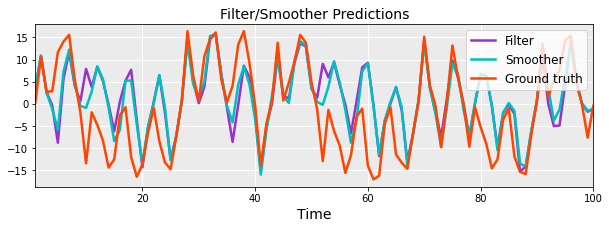

--------------------
Gaussian filter
--------------------
RMSE: 8.202958550919044
NLL: 7.746571806691787
--------------------
Gaussian smoother
--------------------
RMSE: 7.410609930960062
NLL: 8.80343253912114


In [7]:
# Plot results
filter_means = [state.mean for state in filter_result]
smoother_means = [state.mean for state in smoother_result]
ax = plot_1d_data(np.array(filter_means).T, figsize=(10,3), c='darkorchid', linewidth=2.5, label='Filter')
ax = plot_1d_data(np.array(smoother_means).T, ax=ax, c='c', linewidth=2.5, label='Smoother')
ax = plot_1d_data(np.array(X).T, ax=ax, c='orangered', linewidth=2.5, label='Ground truth')
ax.set_title('Filter/Smoother Predictions', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_xlim(1, timesteps)
plt.legend(loc='upper right', fontsize=12)
plt.show()

# Compute metrics
print("-"*20)
print("Gaussian filter")
print("-"*20)
filter_rmse, filter_nll = rmse(filter_result, X), nll(filter_result, X)
print(f"RMSE: {filter_rmse}")
print(f"NLL: {filter_nll}")

print("-"*20)
print("Gaussian smoother")
print("-"*20)
smoother_rmse, smoother_nll = rmse(smoother_result, X), nll(smoother_result, X)
print(f"RMSE: {smoother_rmse}")
print(f"NLL: {smoother_nll}")

## Approximate EP

We now use (approximate) expectation propagation (EP) to estimate the state X from y. We first create an `Estimator` object, which contain methods for moment matching (i.e. projection). We specify the transformation type used for implicit/explicit linearisation, error covariances (for both transition and measurement) and power/damping factors. Here, we stick to the unscented transform for linearisation and set both power and damping factors to one. 

In [23]:
trans_type = 'UT'
sys_dim = 1 # This is the dimension of the system
transform, meas_transform = select_transform(trans_type, dim=sys_dim)

estim = Estimator(trans_map=transform,
                  meas_map=meas_transform,
                  trans_noise=system.transition_noise.cov,
                  meas_noise=system.measurement_noise.cov,
                  power=1.0,
                  damping=1.0)

Next, set up the nodes in our factor graph.

In [9]:
# Specify the length of the timeseries and dimension of the system when building the nodes
nodes = build_nodes(N=timesteps, dim=sys_dim)
# Add estimator
nodes = node_estimator(nodes=nodes, estimator=estim)
# Add system and measurements
nodes = node_system(nodes=nodes, system_model=system, measurements=y)

Apply a single EP iteration to the graph as follows.

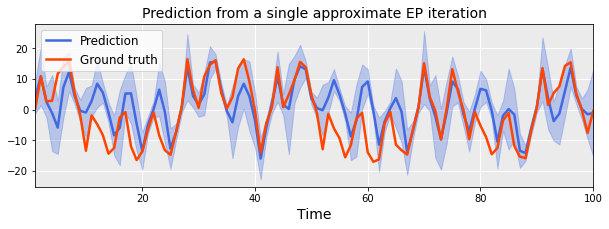

In [10]:
# Apply a single forward-backward EP sweep
ep_fwd_back_updates(nodes)

# Plot results
fig = plt.figure(figsize=(10,3))
ax = fig.gca()
ax = plot_gaussian_node(nodes, X, ax=ax, colors=['royalblue', 'orangered'])
ax.set_title('Prediction from a single approximate EP iteration', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_xlim(1, timesteps)
plt.legend(fontsize=12)
plt.show()

Compare results with that of the corresponding Kalman-type smoother.

In [11]:
# Compute metrics
ep_rmse_1, ep_nll_1 = node_metrics(nodes, X)

print("-"*20)
print("Single EP iteration")
print("-"*20)
print(f"RMSE: {ep_rmse_1}")
print(f"NLL: {ep_nll_1}")

print("-"*20)
print("Gaussian smoother")
print("-"*20)
print(f"RMSE: {smoother_rmse}")
print(f"NLL: {smoother_nll}")

--------------------
Single EP iteration
--------------------
RMSE: 7.410582938007571
NLL: 8.803391233734992
--------------------
Gaussian smoother
--------------------
RMSE: 7.410609930960062
NLL: 8.80343253912114


We see that the results are nearly identical as expected.

We can further iterate the EP algorithm to refine the estimates. Below, we iterate EP nine more times.

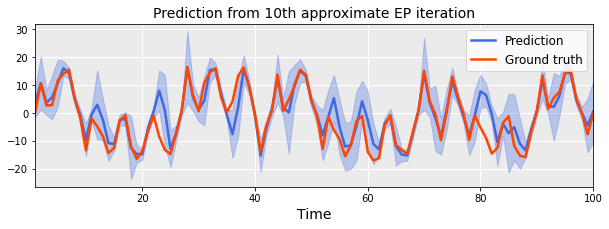

In [12]:
for i in range(9):
    ep_fwd_back_updates(nodes)

# Plot results
fig = plt.figure(figsize=(10,3))
ax = fig.gca()
ax = plot_gaussian_node(nodes, X, ax=ax, colors=['royalblue', 'orangered'])
ax.set_title('Prediction from 10th approximate EP iteration', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_xlim(1, timesteps)
plt.legend(fontsize=12)
plt.show()

In [13]:
# Compare with first iteration
ep_rmse_10, ep_nll_10 = node_metrics(nodes, X)

print("-"*20)
print("Single EP iteration")
print("-"*20)
print(f"RMSE: {ep_rmse_1}")
print(f"NLL: {ep_nll_1}")

print("-"*20)
print("10th EP iteration")
print("-"*20)
print(f"RMSE: {ep_rmse_10}")
print(f"NLL: {ep_nll_10}")

--------------------
Single EP iteration
--------------------
RMSE: 7.410582938007571
NLL: 8.803391233734992
--------------------
10th EP iteration
--------------------
RMSE: 4.631251225353462
NLL: 3.131116767807924


We see that for this example, using the unscented transform for implicit linearisation, the results in terms of both the RMSE and NLL have improved.

## Damped power EP

A well-known problem with iterating EP is that there is no convergence guarantee. For highly nonlinear problems such as the one we consider here, the results may oscillate significantly. A heuristic approach to reduce this oscillation is to apply _damping_ in the updates, which is akin to taking smaller learning rates in gradient-based learning.

We may also improve the results and help reduce the oscillations further by consider _power EP_. In power EP, the objective is to minimize the $\alpha$-divergence for $\alpha \in [0, \infty]$ instead of the Kullback-Leibler divergence (which arises as a special case $\alpha=1$). By choosing $\alpha < 1$, we can make the predictions more mode-seeking, which may be useful in settings where the posteriors are multi-modal. However, choosing $\alpha$ too small may also be detrimental to the performance.

Below, we set both power and damping to 0.8 and plot the results at different iterations.

In [40]:
# Build EP nodes for damped power EP
trans_type = 'UT'
power = 0.8
damping = 0.8
transform, meas_transform = select_transform(trans_type, dim=sys_dim)
estim = Estimator(trans_map=transform,
                meas_map=meas_transform,
                trans_noise=system.transition_noise.cov,
                meas_noise=system.measurement_noise.cov,
                power=power,
                damping=damping)

nodes = build_nodes(N=timesteps, dim=sys_dim)
nodes = node_estimator(nodes=nodes, estimator=estim)
nodes = node_system(nodes=nodes, system_model=system, measurements=y)


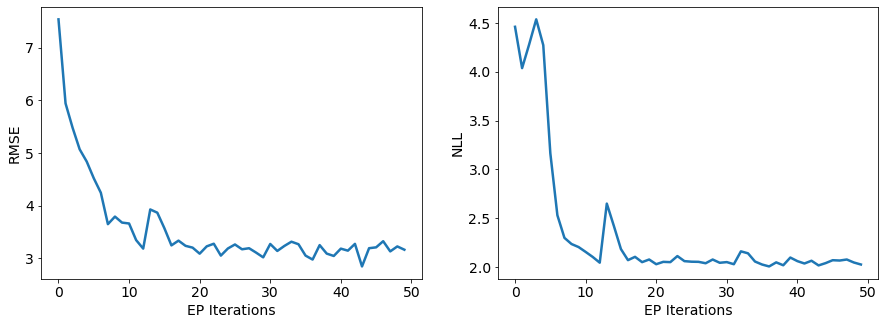

In [41]:
# Run EP iteration
max_iter = 50
nodes_list = []
rmse_list, nll_list = [], []

for i in range(max_iter):
    ep_fwd_back_updates(nodes)       
    nodes_list.append(deepcopy(nodes))
    rmse_, nll_ = node_metrics(nodes, X)
    rmse_list.append(rmse_)
    nll_list.append(nll_)

# Plot metrics wrt iterations
fig, axs = plt.subplots(1,2, figsize=(15, 5))
metrics = {'RMSE': rmse_list, 'NLL': nll_list}
for i, item in enumerate(metrics.items()):
    key, value = item
    axs[i].plot(value, linewidth=2.5)
    axs[i].set_ylabel(key, fontsize=14)
    axs[i].set_xlabel('EP Iterations', fontsize=14)
plt.show()

Above, we see good convergence behaviour in the metrics. Let us now plot the predictions at different EP iterations.

In [42]:
def plot_smoother_results(nodes_list, iter_list, rmse_list, nll_list, ground_truth, vmin=None, vmax=None, colors=['C0', 'C2'], figsize=None):
    fig, axs = plt.subplots(len(nodes_list), figsize=figsize)
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    for i, params in enumerate(zip(nodes_list, iter_list, rmse_list, nll_list)):
        nodes, iter, rmse, nll = params
        ax = plot_gaussian_node(nodes, ground_truth, ax=axs[i], colors=colors)
        ax.set_title(f"(Iteration {iter+1}) RMSE={rmse:.2f}, NLL={nll:.2f}", fontsize=16)
        if i == len(nodes_list)-1:
            ax.set_xlabel("Time steps", fontsize=16)
        ax.set_ylim(vmin, vmax)
        ax.set_xlim(1, timesteps)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if i == 0:
            ax.legend(loc='upper right', bbox_to_anchor=(1.04, 1.0), ncol=2, fontsize=12)
    plt.tight_layout()

    return ax

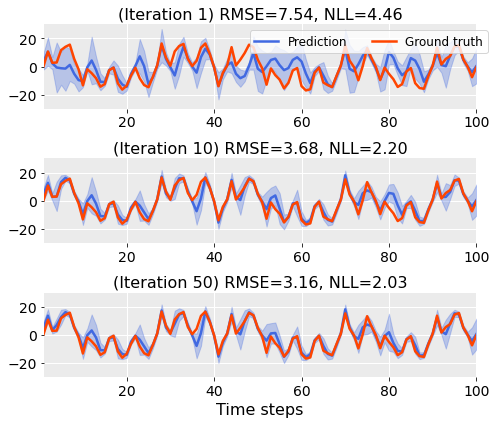

In [44]:
# Display predictions and associated metrics for iterations 1, 10 and 50
iters = [0, 9, 49]
nodes_to_plot = [nodes_list[i] for i in iters]
rmse_list_new = [rmse_list[i] for i in iters]
nll_list_new = [nll_list[i] for i in iters]
ax = plot_smoother_results(nodes_to_plot, iters, rmse_list_new, nll_list_new, X, figsize=(7,6), vmin=-30, vmax=30, colors=['royalblue', 'orangered'])
# ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1.1), ncol=2)
# plt.savefig(f"figs/Smoother_results_power_{power}_damp_{damping}.pdf")

We see that the results after 50 iterations of damped power EP is better than the results we saw for standard EP.